# EDA
Objective: To predict the No-Show of customers (using the dataset provided) to help a hotel chain to formulate policies to reduce expenses incurred due to No-Shows

Your EDA should:
• Outline the steps taken in the EDA process
• Explain the purpose of each step
• Explain the conclusions drawn from each step
• Explain the interpretation of the various statistics generated and how they impact your
analysis
• Generate clear, meaningful, and understandable visualizations that support your findings
• Organize the notebook so that is it clear and easy to understand 

### Data Set-up

In [118]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create an engine
engine = create_engine('sqlite:///data/noshow.db')

df = pd.read_sql("SELECT * FROM noshow", con=engine)

print(df.head())

   booking_id  no_show   branch booking_month arrival_month  arrival_day  \
0       94113      0.0   Changi      November          June         25.0   
1       86543      0.0  Orchard        August      November         28.0   
2       75928      0.0   Changi         March      February          7.0   
3       66947      1.0  Orchard     September       October          1.0   
4      106390      0.0  Orchard         March          June         20.0   

  checkout_month  checkout_day    country first_time    room         price  \
0           June          27.0  Singapore        Yes  Single   SGD$ 492.98   
1       November          29.0  Indonesia        Yes    King  SGD$ 1351.22   
2       February          11.0      India        Yes  Single          None   
3        October           3.0      China        Yes  Single   SGD$ 666.04   
4           June          24.0  Australia        Yes   Queen   USD$ 665.37   

  platform num_adults  num_children  
0  Website          1           0.0 

In [119]:
df.describe()

,booking_id,no_show,arrival_day,checkout_day,num_children
count,119391.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,59695.000000,0.370416,15.798241,14.250507,0.871229
std,34465.357332,0.482918,8.780829,11.063697,0.779796
min,0.000000,0.000000,1.000000,-31.000000,0.000000
25%,29847.500000,0.000000,8.000000,7.000000,0.000000
50%,59695.000000,0.000000,16.000000,15.000000,1.000000
75%,89542.500000,1.000000,23.000000,23.000000,1.000000
max,119390.000000,1.000000,31.000000,31.000000,3.000000


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119391 entries, 0 to 119390
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   booking_id      119391 non-null  int64  
 1   no_show         119390 non-null  float64
 2   branch          119390 non-null  object 
 3   booking_month   119390 non-null  object 
 4   arrival_month   119390 non-null  object 
 5   arrival_day     119390 non-null  float64
 6   checkout_month  119390 non-null  object 
 7   checkout_day    119390 non-null  float64
 8   country         119390 non-null  object 
 9   first_time      119390 non-null  object 
 10  room            97778 non-null   object 
 11  price           94509 non-null   object 
 12  platform        119390 non-null  object 
 13  num_adults      119390 non-null  object 
 14  num_children    119390 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 13.7+ MB


### Data Preprocessing, Cleaning and Validation

Most features have 1 missing value except for room and price.

In [121]:
print(df.isnull().sum())

booking_id            0
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64


The missing values count indicates:
- room has 21,613 missing values (~18% missing).
- price has 24,882 missing values (~21% missing).
- Other columns have only 1 missing value, which can easily be filled or dropped.

We shall impute missing values for critical features like price or room. 
For room, we can fill missing values with "Unknown" as rooms are categorical.
For price, we can impute the missing values with median price per room type to prevent skewing of data and keep reasonable price estimates.
Other columns we can drop the 1 missing row as dropping only 1 row will not harm the model.

Additionally, some columns like price, num_adults, num_children are still in object format and we would have to change their format to numeric.

In [122]:
# Step 1: Handle missing values

# Fill missing values in 'room' with 'Unknown' (since it's categorical)
df['room'] = df['room'].fillna('Unknown')

# Fill missing values in 'price' with median price per room type
# First, we need to convert 'price' to numeric (remove SGD$ or USD$ from the price)
df['price'] = df['price'].replace({r'SGD\$': '', r'USD\$': ''}, regex=True).astype(float)

# Fill missing price with the median price per room type
df['price'] = df.groupby('room')['price'].transform(lambda x: x.fillna(x.median()))

# Drop rows with only 1 missing value (since it's very few and won't harm the dataset)
df.dropna(subset=['no_show', 'branch', 'booking_month', 'arrival_month', 'arrival_day',
                  'checkout_month', 'checkout_day', 'country', 'first_time', 'platform',
                  'num_adults', 'num_children'], inplace=True)

In [123]:
# Check unique values in the column to find any non-numeric entries
print(df['num_adults'].unique())

['1' '2' 'one' 'two']


In [124]:
# Step 2: Convert data types

# Convert 'num_adults' and 'num_children' to numeric types
# Replace 'one' with 1 and 'two' with 2, and convert to numeric
df['num_adults'] = df['num_adults'].replace({'one': 1, 'two': 2})

# Convert the 'num_adults' column to numeric (coerce errors to NaN for any remaining invalid values)
df['num_adults'] = pd.to_numeric(df['num_adults'], errors='coerce')

# Fill missing values with the median value of 'num_adults'
df['num_adults'].fillna(df['num_adults'].median(), inplace=True)

df['num_children'] = pd.to_numeric(df['num_children'], errors='coerce')

# For 'price', the conversion was already done above
# Now we can check the data types after conversion
print(df.dtypes)


booking_id          int64
no_show           float64
branch             object
booking_month      object
arrival_month      object
arrival_day       float64
checkout_month     object
checkout_day      float64
country            object
first_time         object
room               object
price             float64
platform           object
num_adults          int64
num_children      float64
dtype: object


C:\Users\admin'\AppData\Local\Temp\ipykernel_30316\4003547606.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['num_adults'].fillna(df['num_adults'].median(), inplace=True)


In [125]:
# Verify if there are still missing values
print(df.isnull().sum())

booking_id        0
no_show           0
branch            0
booking_month     0
arrival_month     0
arrival_day       0
checkout_month    0
checkout_day      0
country           0
first_time        0
room              0
price             0
platform          0
num_adults        0
num_children      0
dtype: int64


In [126]:
# Check if 'Unknown' was added for missing rooms
print(df['room'].value_counts())

room
King               70496
Unknown            21612
Single             15697
Queen              10824
President Suite      761
Name: count, dtype: int64


In [145]:
# Standardize capitalization of arrival_month
df['Arrival_month'] = df['Arrival_month'].str.capitalize()

### Data Visualisation

Let's visualise our numeric variables using a histogram

array([[<Axes: title={'center': 'booking_id'}>,
        <Axes: title={'center': 'no_show'}>,
        <Axes: title={'center': 'arrival_day'}>],
       [<Axes: title={'center': 'checkout_day'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'num_adults'}>],
       [<Axes: title={'center': 'num_children'}>, <Axes: >, <Axes: >]],
      dtype=object)

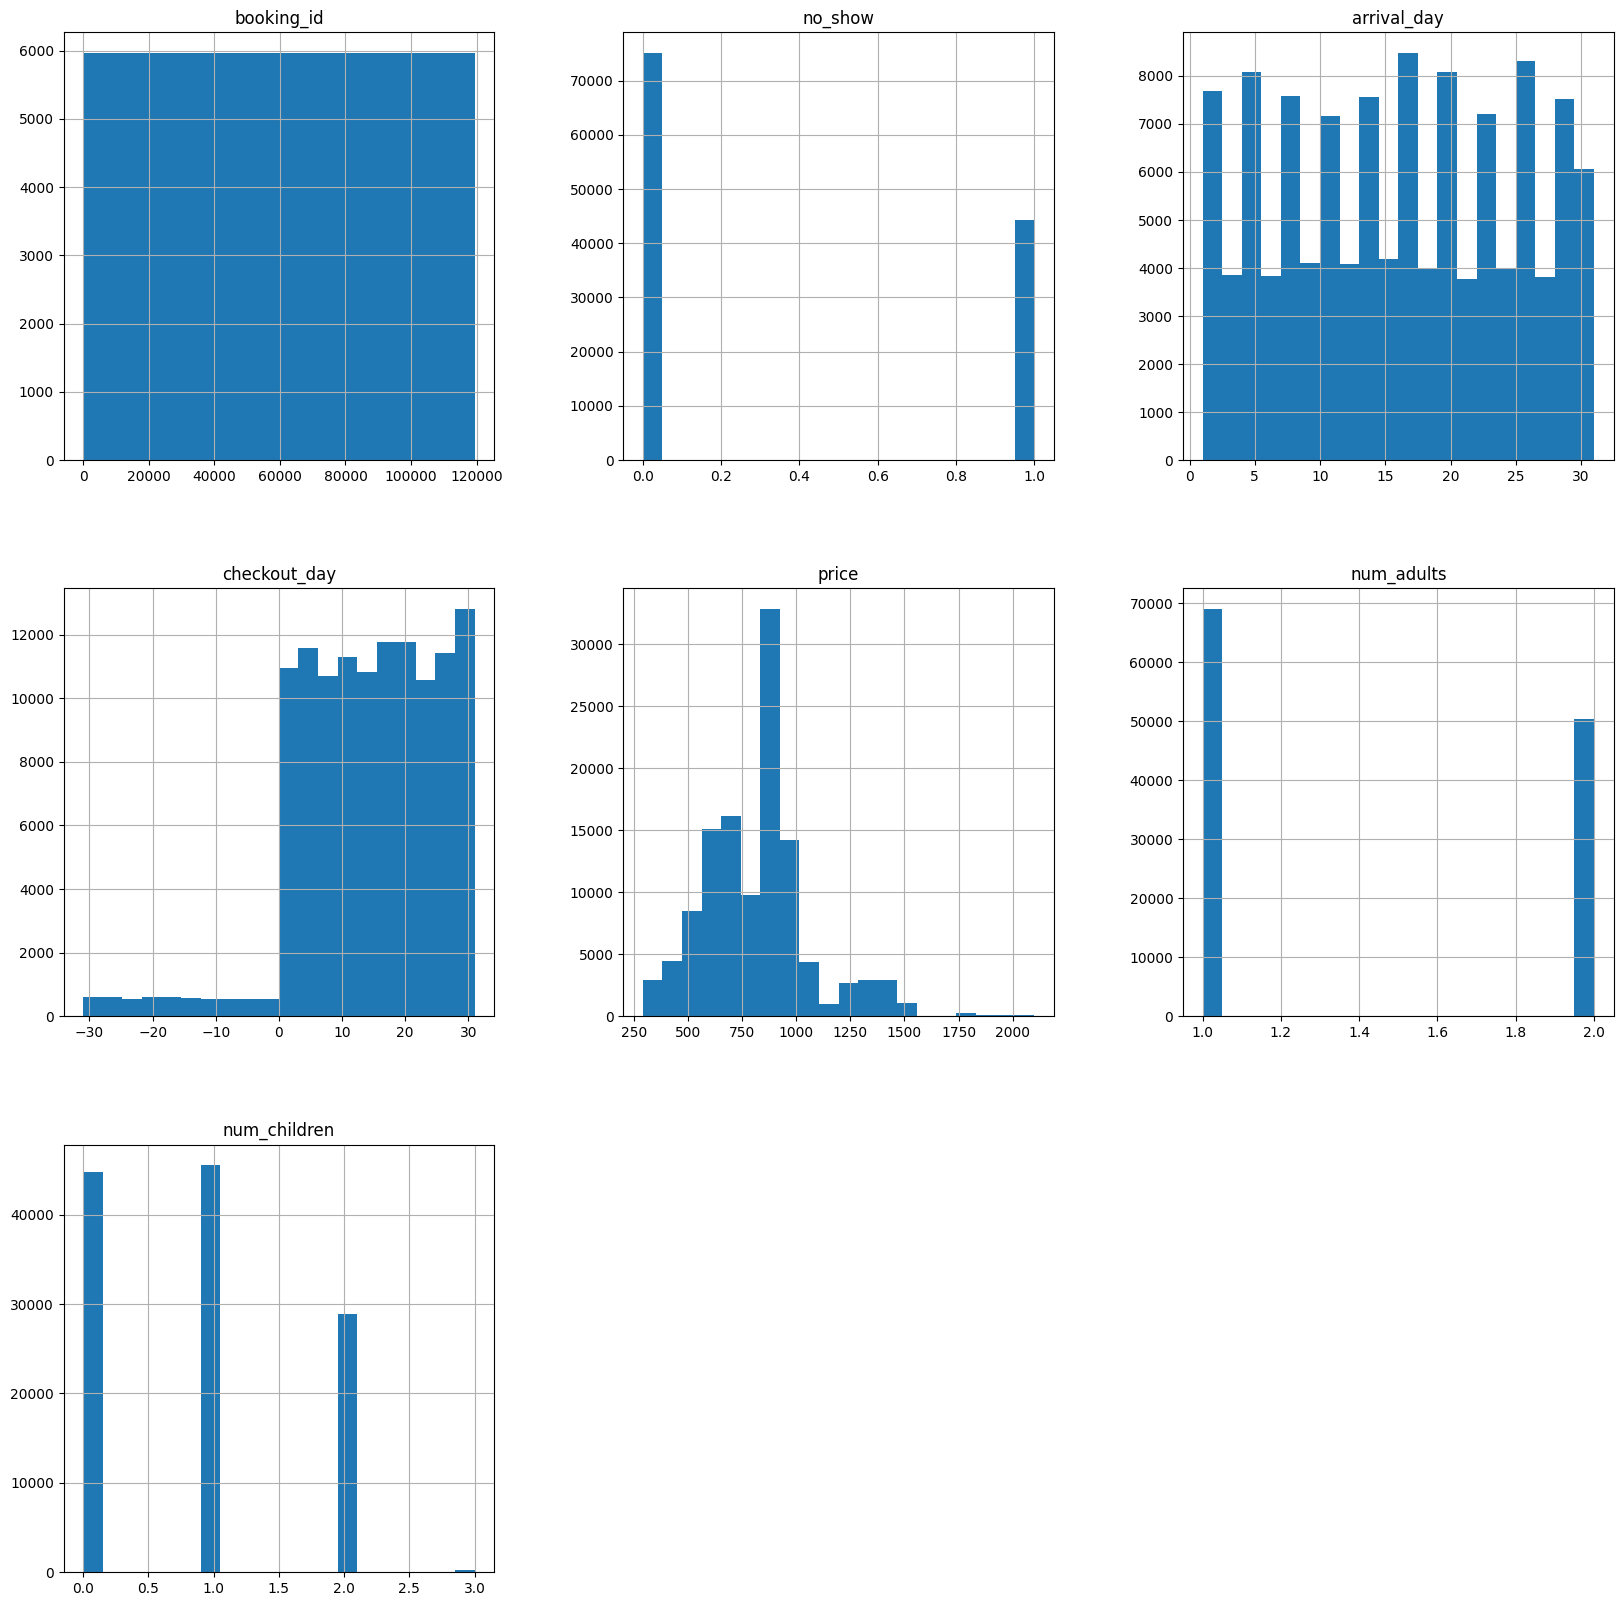

In [127]:
df.hist(figsize=(20,20), bins=20)

In [128]:
import numpy as np
df_num = df.select_dtypes(include=np.number)
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119390 entries, 0 to 119390
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   booking_id    119390 non-null  int64  
 1   no_show       119390 non-null  float64
 2   arrival_day   119390 non-null  float64
 3   checkout_day  119390 non-null  float64
 4   price         119390 non-null  float64
 5   num_adults    119390 non-null  int64  
 6   num_children  119390 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 7.3 MB


In [129]:
# Check correlations between all the variables using corr()

df_num_corr = df_num.corr()['no_show']
df_num_corr

booking_id      0.002261
no_show         1.000000
arrival_day    -0.006130
checkout_day   -0.015413
price          -0.037577
num_adults      0.014506
num_children    0.018968
Name: no_show, dtype: float64

None of the numerical features have a strong correlation with no_show.
The highest absolute correlation is price (-0.0376), which is still very weak.

booking_id (0.0023): This is just an identifier and has no predictive power. You can safely drop it.

arrival_day (-0.0061) and checkout_day (-0.0154): Very weak correlations. It might be worth checking if grouping these into "weekend vs. weekday" categories provides better insights.

price (-0.0376): Weak negative correlation, meaning higher prices slightly reduce no-shows. However, this needs further analysis.

num_adults (0.0145) and num_children (0.018968): Weak positive correlation. We can try to check their interaction together.

<Axes: xlabel='no_show', ylabel='total_guests'>

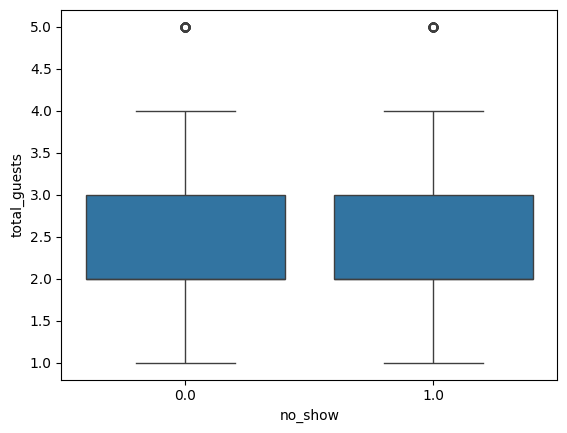

In [130]:
df['total_guests'] = df['num_adults'] + df['num_children']
sns.boxplot(x='no_show', y='total_guests', data=df)

In [131]:
df['arrival_weekend'] = df['arrival_day'].apply(lambda x: 1 if x in [5, 6] else 0)  
df['checkout_weekend'] = df['checkout_day'].apply(lambda x: 1 if x in [5, 6] else 0)
pd.crosstab(df['arrival_weekend'], df['no_show'], normalize='index')

no_show,0.0,1.0
arrival_weekend,,
0,0.629018,0.370982
1,0.637301,0.362699


No significant difference between weekday and weekend arrivals.

In [132]:
pd.crosstab(df['checkout_weekend'], df['no_show'], normalize='index')


no_show,0.0,1.0
checkout_weekend,,
0,0.630582,0.369418
1,0.614899,0.385101


Weekend checkouts have a slightly higher no-show rate (38.5%) compared to weekdays (36.9%).

In [133]:
df['price_category'] = pd.qcut(df['price'], q=4, labels=['low', 'medium', 'high', 'very_high'])
pd.crosstab(df['price_category'], df['no_show'], normalize='index')


no_show,0.0,1.0
price_category,,
low,0.635054,0.364946
medium,0.604410,0.395590
high,0.606620,0.393380
very_high,0.672251,0.327749


Lower price bookings tend to have higher no-show rates (medium = 39.6%, high = 39.3%).
Very high price bookings have the lowest no-show rate (32.8%), meaning customers paying more are more likely to show up.
Price is a useful predictive feature—consider keeping it as a categorical variable.


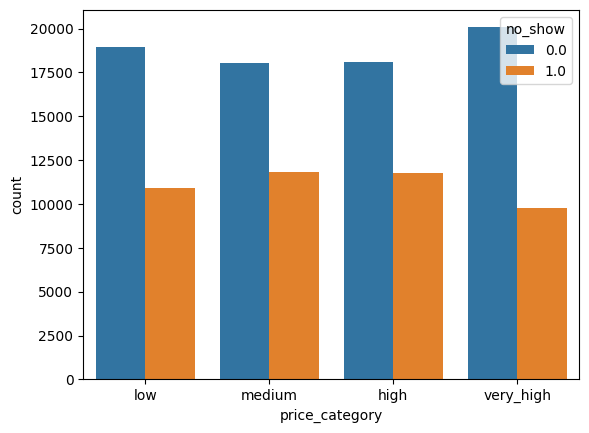

In [134]:
sns.countplot(x='price_category', hue='no_show', data=df, order=['low', 'medium', 'high', 'very_high'])
plt.show()


In [135]:
df.drop(columns=['booking_id', 'arrival_weekend'], inplace=True)

In [136]:
df['price_guests_interaction'] = df['price_category'].astype(str) + "_" + df['total_guests'].astype(str)

Performing a Chi-Square Test for Statistical Significance

In [137]:
from scipy.stats import chi2_contingency

# Price Category vs. No-Show
price_ct = pd.crosstab(df['price_category'], df['no_show'])

# Checkout Weekend vs. No-Show
checkout_ct = pd.crosstab(df['checkout_weekend'], df['no_show'])

# Price-Guest Interaction vs. No-Show
price_guest_ct = pd.crosstab(df['price_guests_interaction'], df['no_show'])


In [138]:
# Function to run chi-square test
def chi_square_test(table):
    chi2, p, dof, expected = chi2_contingency(table)
    return p

# Run tests
p_price = chi_square_test(price_ct)
p_checkout = chi_square_test(checkout_ct)
p_price_guest = chi_square_test(price_guest_ct)

# Display results
print(f"P-value (Price Category vs. No-Show): {p_price}")
print(f"P-value (Checkout Weekend vs. No-Show): {p_checkout}")
print(f"P-value (Price-Guest Interaction vs. No-Show): {p_price_guest}")


P-value (Price Category vs. No-Show): 3.198195418671979e-83
P-value (Checkout Weekend vs. No-Show): 0.006391727112451917
P-value (Price-Guest Interaction vs. No-Show): 3.923792668232972e-110


If p-value < 0.05, the feature has a statistically significant relationship with no_show, meaning it could be useful in predicting no-shows.
If p-value ≥ 0.05, the feature is not significant, and we may consider removing it from our model.

Price Category, Checkout Weekend, Price-Guest Interaction all have a statistically significant relationship with no_show.

booking_id          int64
no_show           float64
branch             object
booking_month      object
arrival_month      object
arrival_day       float64
checkout_month     object
checkout_day      float64
country            object
first_time         object
room               object
price             float64
platform           object
num_adults          int64
num_children      float64


Crosstab for Branch:
 No_show       0.0       1.0
Branch                     
Changi   0.582730  0.417270
Orchard  0.722366  0.277634 



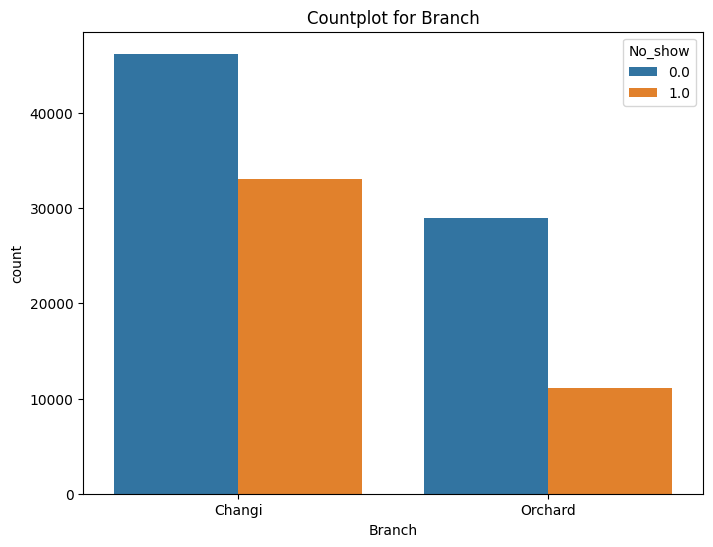

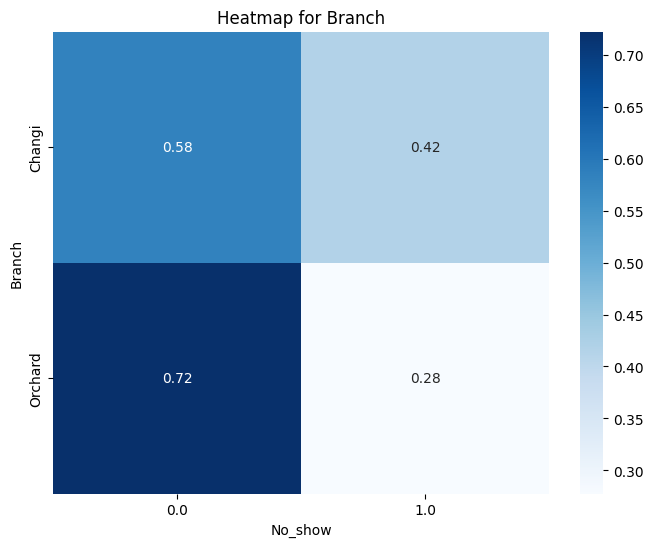

Crosstab for Booking_month:
 No_show             0.0       1.0
Booking_month                    
April          0.608191  0.391809
August         0.637063  0.362937
December       0.625667  0.374333
February       0.661139  0.338861
January        0.649501  0.350499
July           0.604123  0.395877
June           0.590759  0.409241
March          0.635739  0.364261
May            0.646642  0.353358
November       0.642315  0.357685
October        0.638458  0.361542
September      0.617159  0.382841 



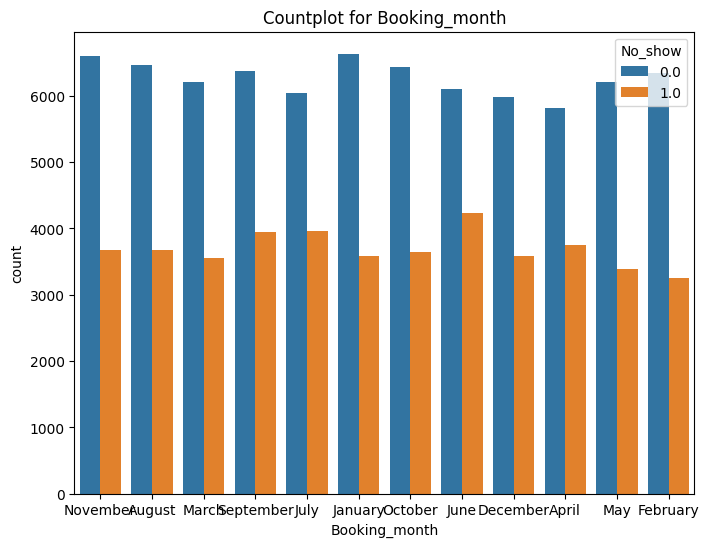

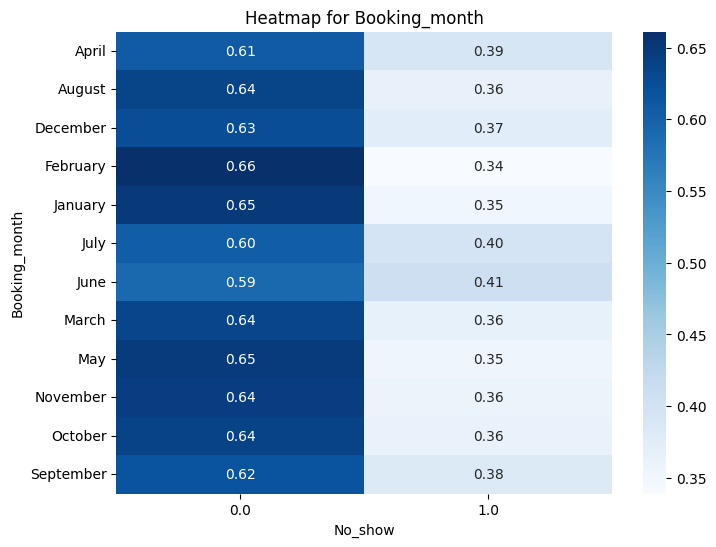

Crosstab for Arrival_month:
 No_show             0.0       1.0
Arrival_month                    
April          0.592028  0.407972
August         0.622469  0.377531
December       0.650295  0.349705
February       0.665840  0.334160
January        0.695227  0.304773
July           0.625464  0.374536
June           0.585428  0.414572
March          0.678477  0.321523
May            0.603342  0.396658
November       0.687666  0.312334
October        0.619534  0.380466
September      0.608298  0.391702 



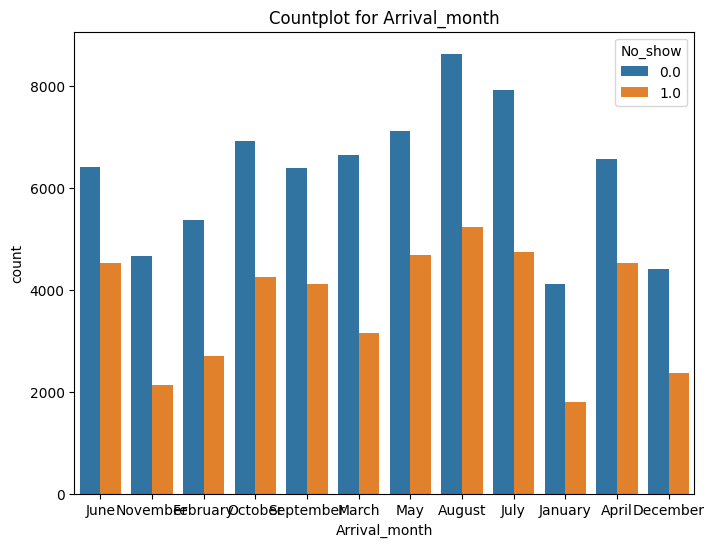

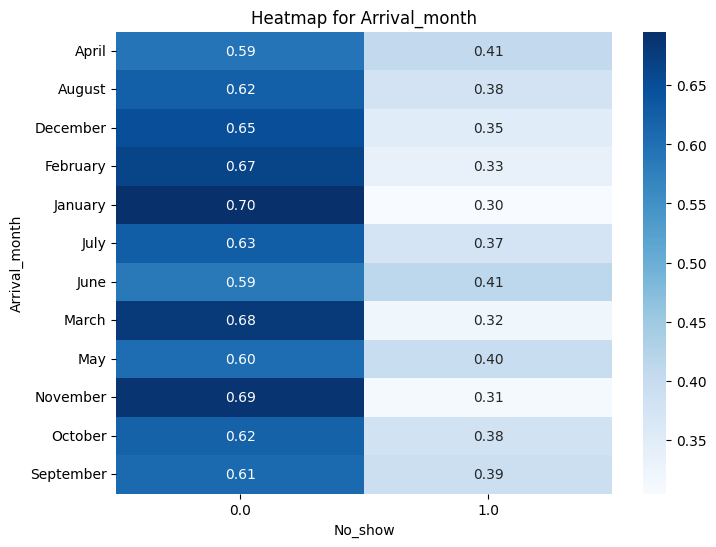

Crosstab for Checkout_month:
 No_show              0.0       1.0
Checkout_month                    
April           0.600763  0.399237
August          0.620916  0.379084
December        0.649832  0.350168
February        0.674961  0.325039
January         0.691682  0.308318
July            0.623589  0.376411
June            0.579405  0.420595
March           0.674309  0.325691
May             0.602292  0.397708
November        0.681175  0.318825
October         0.616057  0.383943
September       0.615687  0.384313 



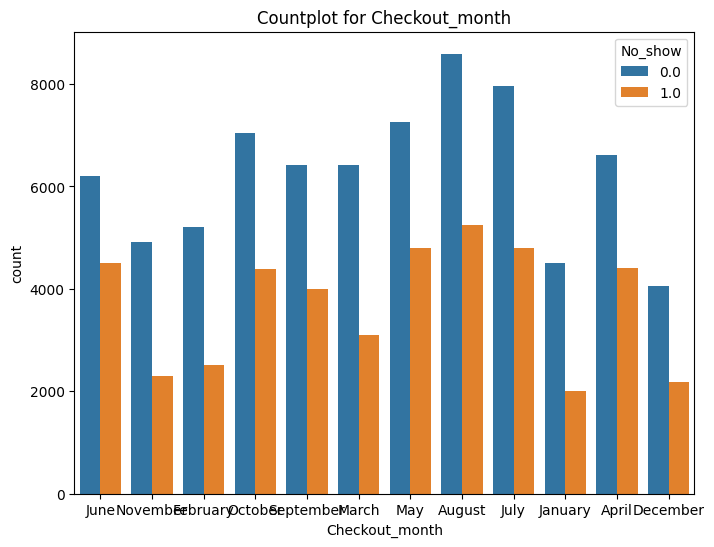

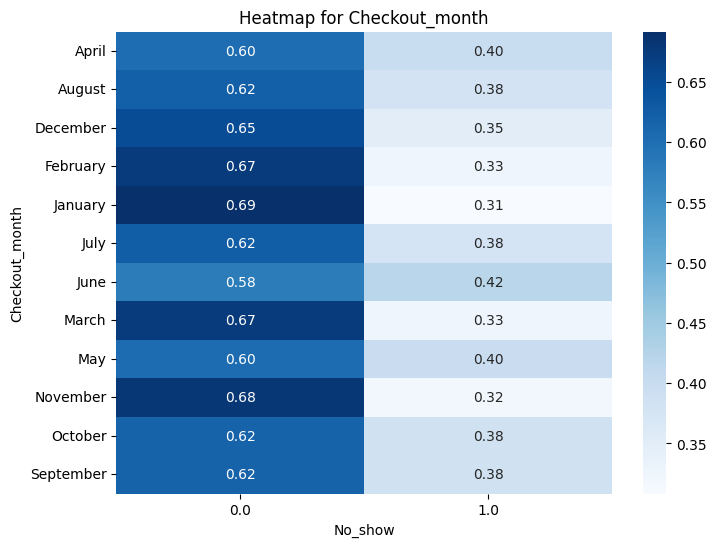

Crosstab for Country:
 No_show         0.0       1.0
Country                      
Australia  0.797757  0.202243
China      0.433649  0.566351
India      0.779544  0.220456
Indonesia  0.732915  0.267085
Japan      0.829092  0.170908
Malaysia   0.646044  0.353956
Singapore  0.759969  0.240031 



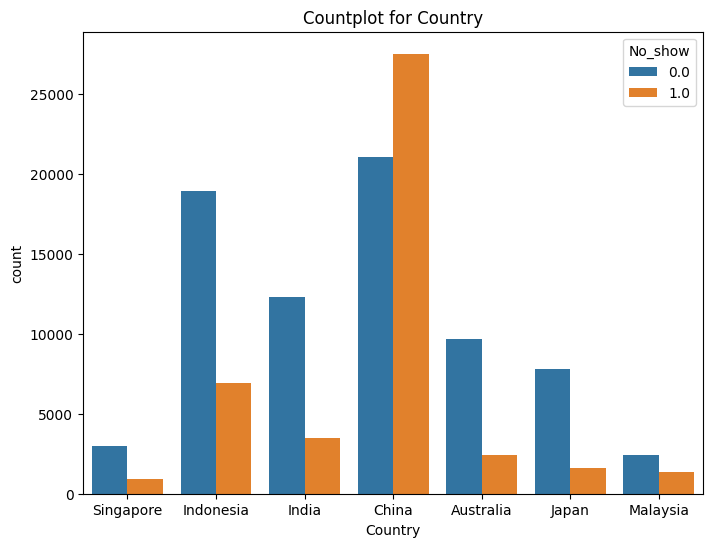

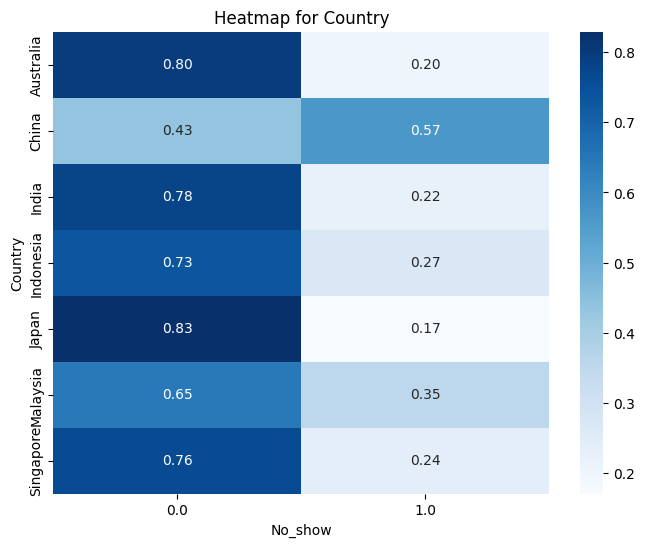

Crosstab for First_time:
 No_show          0.0       1.0
First_time                    
No          0.855118  0.144882
Yes         0.622149  0.377851 



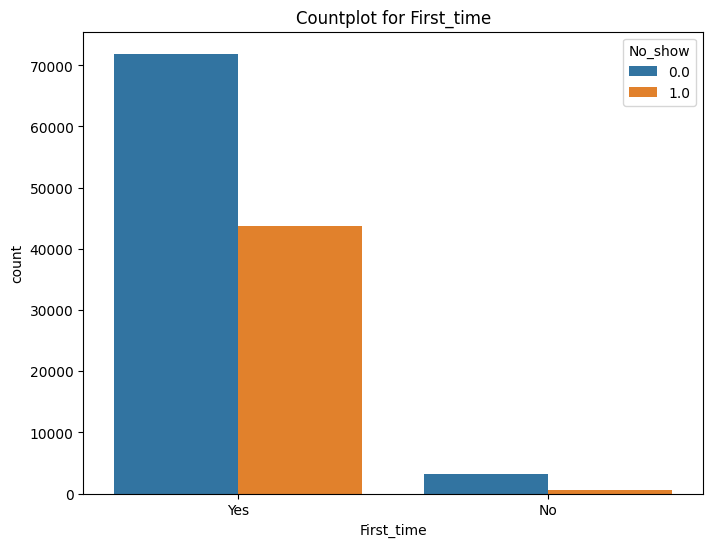

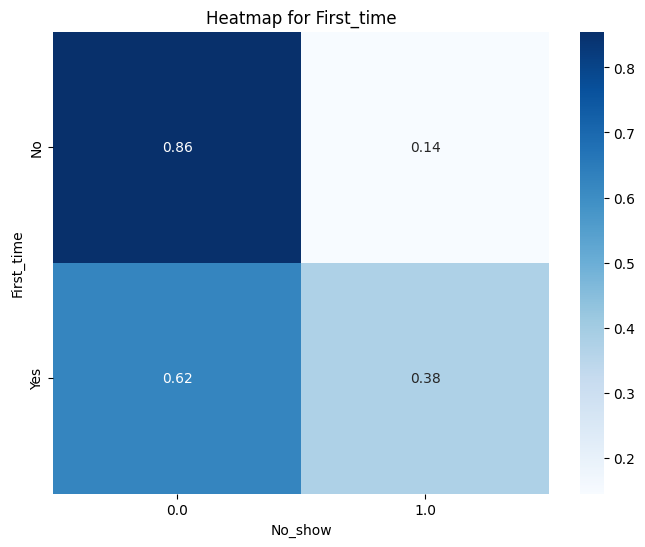

Crosstab for Room:
 No_show               0.0       1.0
Room                               
King             0.608247  0.391753
President Suite  0.657030  0.342970
Queen            0.686438  0.313562
Single           0.681149  0.318851
Unknown          0.632288  0.367712 



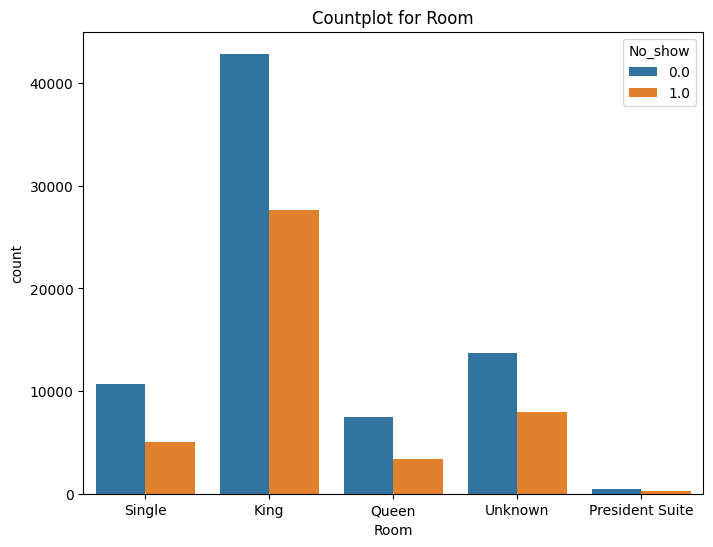

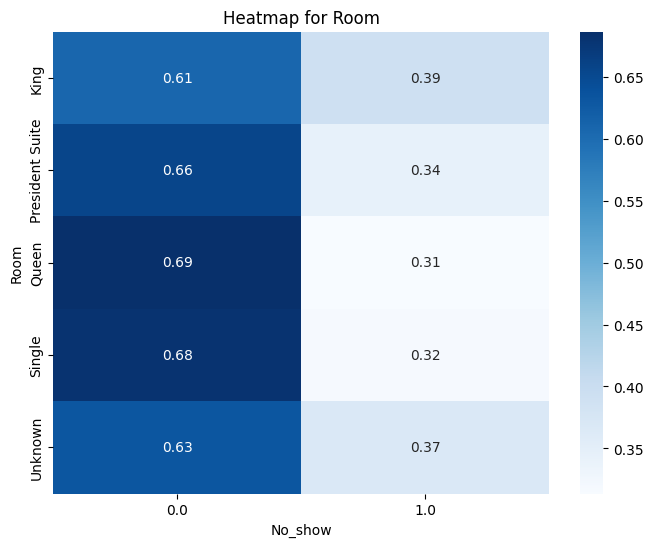

Crosstab for Platform:
 No_show        0.0       1.0
Platform                    
Agent     0.630136  0.369864
Email     0.625429  0.374571
Phone     0.637381  0.362619
Website   0.630306  0.369694 



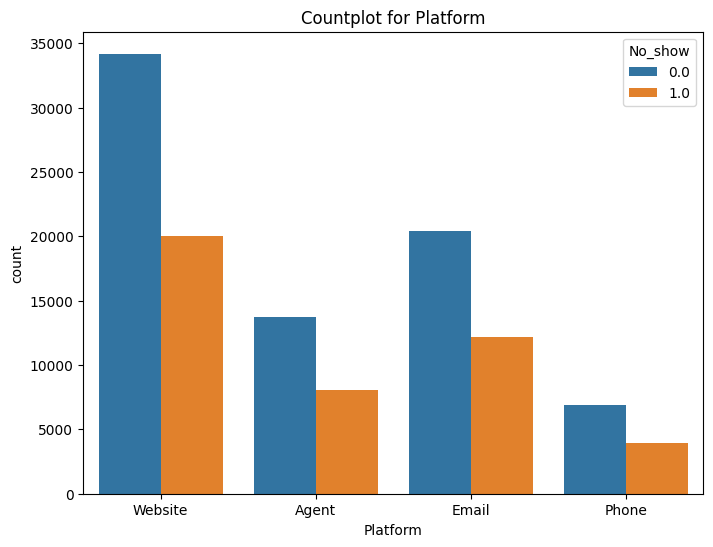

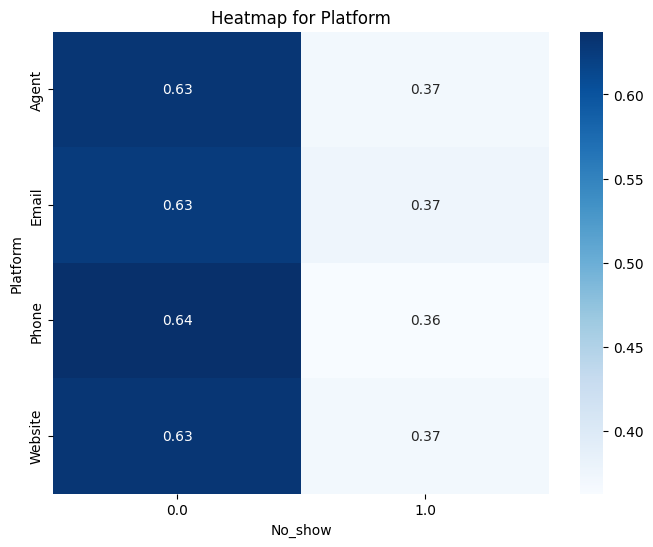

In [146]:
# Clean column names to standardize capitalization
df.columns = df.columns.str.capitalize()

# List of columns to analyze
columns_to_analyze = ['Branch', 'Booking_month', 'Arrival_month', 'Checkout_month', 
                      'Country', 'First_time', 'Room', 'Platform']

# Loop through columns and generate crosstabs and count plots
for col in columns_to_analyze:
    # Crosstab and display the result with a percentage format
    crosstab_result = pd.crosstab(df[col], df['No_show'], normalize='index')
    print(f"Crosstab for {col}:\n", crosstab_result, "\n")
    
    # Plot the countplot for each category
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='No_show', data=df)
    plt.title(f'Countplot for {col}')
    plt.show()
    
    # Optionally, you can plot the heatmap for the crosstab results for better visual inspection
    plt.figure(figsize=(8, 6))
    sns.heatmap(crosstab_result, annot=True, cmap="Blues", fmt=".2f", cbar=True)
    plt.title(f'Heatmap for {col}')
    plt.show()
